# Attentionの仕組み

## seq2seqの問題点

seq2se2の問題点はどんな長さの入力文でも固定長のベクトルにしてしまうことです。  
これでは必要な情報がうまく伝達できないのです。

## Encoderの改良

そのため、Encoderの出力は入力される文章の長さに応じて、その長さを変えるべきです。  
つまり、可変長のベクトルにするために、LSTMレイヤの隠れ状態のベクトルを全て利用するのです。

## Decoderの改良

### Encoderの出力を全て使う

先ほど、Encoderの改良の部分でLSTMレイヤの隠れ状態のベクトル（hsと呼びます）を全て使うと言いましたが、  
そのベクトルをDecoderで使用していきます。  
今まではhsの最後の行のみをDecoderに渡していましたが、これを全て渡していくことが1つめの改良です。

In [1]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

(5, 4)


In [2]:
t = hs * ar
print(t.shape)

(5, 4)


In [3]:
c = np.sum(t, axis=0)
print(c.shape)

(4,)


In [9]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1)

In [10]:
t = hs * ar
print(t.shape)

(10, 5, 4)


In [11]:
c = np.sum(t, axis=1)
print(c.shape)

(10, 4)


In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

これでhsを全て利用する準備が整いました。

### 各単語の重要度を表す重み"a"

EncoderのLSTMレイヤの出力全てをhsと言っていました。  
DecoderのLSTMレイヤの1つの出力をhとすると、hsの中からhに似ているベクトルを探すということをします。  
それにはhsとhで内積をとります。これで各単語の重要度を表す重みを得ることができるのです。

In [12]:
import sys
sys.path.append('./deep-learning-from-scratch-2')
from common.layers import Softmax

In [15]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1)

In [16]:
t = hs * ar
print(t.shape)

(10, 5, 4)


In [17]:
s = np.sum(t, axis=2)
print(s.shape)

(10, 5)


In [18]:
softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5)


In [ ]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N , T, H = hs.shape
        
        hr = h.reshape(N, 1, H)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, 1, H).repeat(N, T, H)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

これで各単語の重要度の重みを取ってくる準備ができました。最後に1つめの改良と今回の改良を組み合わせます。

### Attentionレイヤ

この組み合わせがまさにAttentionの核心です。それではAttentionレイヤを実装します。  

In [ ]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.foward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, da):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

これでAttentionレイヤが実装できました。次はTimeAttentionレイヤを実装します。

In [ ]:
class TimeAttention:
    def __init__(self):
        self.parmas, self.grads = [], []
        self.layers = None
        self.attention_weight = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

これでTimeAttentionを実装することができました。次はAttentionを使って学習を行なっていきます。

# 実装

## AttentionEncoderの実装

In [19]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

In [ ]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## AttentionDecoderの実装

In [ ]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2 * H, V) / np.sqrt(2 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2
        
        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)
        
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))
            
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)
        
        return sampled

## AttentionSeq2seqの実装

In [20]:
from ch07.seq2seq import Encoder, Seq2seq

In [ ]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# 学習

In [21]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

## Attention

In [22]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 7[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 14[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 21[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 28[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 35[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 42[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 49[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 56[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 63[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 70[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 77[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 84[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 92[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 99[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 106[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 113[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 120[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978

KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

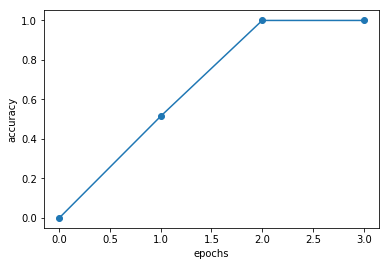

In [25]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

## baseline

In [26]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 5
max_grad = 5.0

# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

y_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    y_acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 4[s] | loss 3.34
| epoch 1 |  iter 41 / 351 | time 8[s] | loss 1.95
| epoch 1 |  iter 61 / 351 | time 12[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 16[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 20[s] | loss 1.55
| epoch 1 |  iter 121 / 351 | time 24[s] | loss 1.27
| epoch 1 |  iter 141 / 351 | time 28[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 32[s] | loss 1.12
| epoch 1 |  iter 181 / 351 | time 36[s] | loss 1.08
| epoch 1 |  iter 201 / 351 | time 40[s] | loss 1.06
| epoch 1 |  iter 221 / 351 | time 44[s] | loss 1.05
| epoch 1 |  iter 241 / 351 | time 48[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 52[s] | loss 1.04
| epoch 1 |  iter 281 / 351 | time 55[s] | loss 1.03
| epoch 1 |  iter 301 / 351 | time 59[s] | loss 1.03
| epoch 1 |  iter 321 / 351 | time 63[s] | loss 1.03
| epoch 1 |  iter 341 / 351 | time 67[s] | loss 1.02
Q 10/15/94                     
T 1994-10-15
☒ 1999-01-

val acc 0.020%


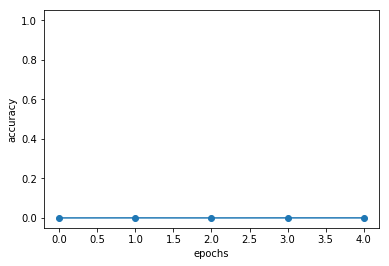

In [27]:
# グラフの描画
y = np.arange(len(y_acc_list))
plt.plot(y, y_acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

## Peeky

In [28]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 5
max_grad = 5.0

# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

z_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    z_acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 4[s] | loss 2.86
| epoch 1 |  iter 41 / 351 | time 9[s] | loss 1.89
| epoch 1 |  iter 61 / 351 | time 13[s] | loss 1.78
| epoch 1 |  iter 81 / 351 | time 17[s] | loss 1.70
| epoch 1 |  iter 101 / 351 | time 22[s] | loss 1.57
| epoch 1 |  iter 121 / 351 | time 26[s] | loss 1.30
| epoch 1 |  iter 141 / 351 | time 30[s] | loss 1.16
| epoch 1 |  iter 161 / 351 | time 35[s] | loss 1.10
| epoch 1 |  iter 181 / 351 | time 39[s] | loss 1.07
| epoch 1 |  iter 201 / 351 | time 43[s] | loss 1.05
| epoch 1 |  iter 221 / 351 | time 47[s] | loss 1.04
| epoch 1 |  iter 241 / 351 | time 52[s] | loss 1.04
| epoch 1 |  iter 261 / 351 | time 56[s] | loss 1.03
| epoch 1 |  iter 281 / 351 | time 60[s] | loss 1.02
| epoch 1 |  iter 301 / 351 | time 65[s] | loss 1.01
| epoch 1 |  iter 321 / 351 | time 69[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 73[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1971-11-

val acc 99.860%


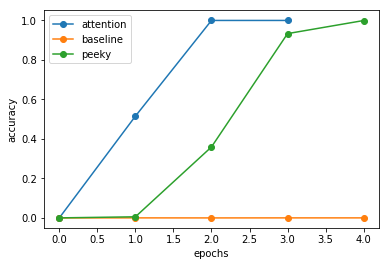

In [30]:
# グラフの描画
z = np.arange(len(z_acc_list))
plt.plot(x, acc_list, marker='o', label='attention')
plt.plot(y, y_acc_list, marker='o', label='baseline')
plt.plot(z, z_acc_list, marker='o', label='peeky')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

見ての通り、Attentionを用いることで学習が一段とうまくいくようになりました。